In [12]:
import numpy as np
from scipy.sparse.linalg import svds 

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

%matplotlib inline

### Просто оператор сдвига для отдельного столбца и матрицы в целом

In [13]:
def shift_operator(matrix, lambdas, column = None):
    A = matrix.copy()
    # for concrete column
    if column != None:
        A[:, column] = np.roll(A[:, column], int(lambdas))
    # for the whole set of columns(lambdas)
    else:
        for i in range(len(lambdas)):
            A[:, i] = np.roll(A[:, i], int(lambdas[i]))
            
    return A

In [14]:
A = np.array([[1,1,1],[2,2,2],[3,3,3]])
l = [1,-1,2]
shift_operator(A, l)

array([[3, 2, 2],
       [1, 3, 3],
       [2, 1, 1]])

## Так как там юзается фурье говно, то еще для него сдвиг, ибо не так просто

In [15]:
def fourier_shift(matrix, lambdas, column = None):
    A = matrix.copy()
    # for concrete column
    if column != None:
        P = np.exp(-2 * np.pi * np.complex(0, 1)/ A.shape[0] * np.arange(A.shape[0]) * lambdas)
        A[:, column] = np.multiply(A[:, column],P)
    # for the whole set of columns(lambdas)
    else:
        P = np.exp(-2 * np.pi * complex(0, 1)/ A.shape[0] * np.arange(A.shape[0]).reshape(A.shape[0], 1) 
                   @ np.array(lambdas).reshape(1, A.shape[1]))
        
        A = np.multiply(A,P)
            
    return A

In [16]:
fourier_shift(A, l)

array([[ 1. +0.j        ,  1. +0.j        ,  1. +0.j        ],
       [-1. -1.73205081j, -1. +1.73205081j, -1. +1.73205081j],
       [-1.5+2.59807621j, -1.5-2.59807621j, -1.5-2.59807621j]])

## Просто первый алгоритм как и в статье, но он объединен с другими же, ибо пункт "solve for lambda_k" жопка

In [17]:
def Algorithm1(A, L):
    l_k = []
    u_k = []
    v_k = []
    
    approx = np.zeros(A.shape)
    iter_gl = 0
    iter_loc = 0
    for i in range(L):
        #3. solve for lanbda_k
        shifts, iter_num_gl, iter_num_loc = Algorithm3(A)
        
        #4. calculate u, v
        #print(shifts)
        u, sigma, v = svds(shift_operator(A, -shifts).astype('complex'), k = 1)
        l_k.append(shifts)
        u_k.append(u @ sigma.reshape(1,1))
        v_k.append(v)
        
        iter_gl += iter_num_gl
        iter_loc += iter_num_loc
        approx = approx + shift_operator(u @ sigma.reshape(1, 1) @ v, shifts)
        #5. update A
        A = A - shift_operator(u @ sigma.reshape(1,1) @ v, shifts).real
    return l_k, u_k, v_k, approx, iter_gl, iter_loc

In [18]:
def Algorithm2(A_f): #algo2 ordinary
    iterations = 0
    shifts = np.zeros(A_f.shape[1])
    
    U = np.repeat(1, A_f.shape[0]) #starting guess
    # 2. Set s = 1
    s = 1
    while s != 0 and iterations < 500:
        # 4. calculate u 1st left singular vector
        U, sigma, v = svds(A_f, k = 1, v0 = U, return_singular_vectors = 'u')
        # 5. Set B
        B = np.abs(np.fft.ifft(np.conjugate(U) * A_f, axis = 0))**2
        # 6. Substract the first row of B from every row
        B = B - B[0]
        # 7. get the position (k, s) of the max in B
        s, k = np.unravel_index(B.argmax(), B.shape)
        # 8. Shift the k-th column of A by -s
        A_f = fourier_shift(A_f, -s, k)
        shifts[k] += s
        iterations += 1  

    return A_f, shifts, iterations 

In [19]:
def Algorithm2_modified(A_f): #algo2 modified
    iterations = 0
    shifts = np.zeros(A_f.shape[1])
    U = np.repeat(1, A_f.shape[0]) #starting guess
    # 2. Set s = 1
    s = 1 
    # (12) calculation u_opt at the modified algo2  
    U_opt, s_opt, v_opt = svds(np.abs(A_f) , k = 1) 

    # 500. Set max_iter to use different maximum number of
    # iterations in global and local step.
    while s!= 0 and iterations < 500:
        U, S, V = svds(A_f, k = 1, v0 = U, return_singular_vectors='u')
        
        U = U * np.abs(U_opt) / np.abs(U) # change directon to find global minimum
        
        B = np.abs(np.fft.ifft(np.conjugate(U) * A_f, axis = 0))**2
        B = B - B[0]
        
        s, k = np.unravel_index(B.argmax(), B.shape) 
        A_f = fourier_shift(A_f, -s, k)
        shifts[k] += s
        iterations += 1
    
    return A_f, shifts, iterations

In [20]:
def Algorithm3(A):
    #1. Input A
    A_f = np.fft.fft(A, axis = 0)
    
    #2. Calculate B
    B = np.abs(np.fft.ifft(np.multiply(np.abs(A_f), A_f), axis = 0))**2 
    
    #3. Set lambda to the indices of the max values of B
    l_max = np.argmax(B, axis = 0)
    
    #global search
    A_f = fourier_shift(A_f, -l_max) 
    A_f, glob_l, glob_iter = Algorithm2_modified(A)
    l_max = l_max + glob_l 
    
    #local search 
    A_f, local_l, local_iter = Algorithm2(A_f)
    shifts =  l_max + local_l

    return shifts, glob_iter, local_iter

In [130]:
image = Image.open('lena.png')
image = np.array(image).astype(np.uint8)

## Считаю ошибку аппроксимации нашего метода во фрабениус норме (в статье также)

In [137]:
from tqdm import tqdm_notebook

errors = []
global_i = []
local_i = []
for L in tqdm_notebook(range(30)):
    l, u, v, A_approx, global_it, local_it = Algorithm1(image.astype('complex'), L)
    error = np.linalg.norm(image - A_approx, ord='fro') / np.linalg.norm(image, ord='fro')
    errors.append(error)
    global_i.append(global_it)
    local_i.append(local_it)
    

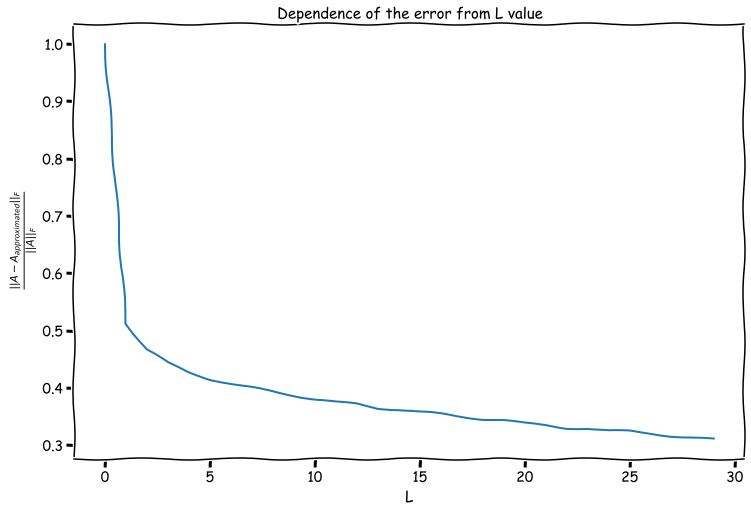

In [230]:
plt.figure(figsize=(12, 8))
plt.xkcd()
plt.grid()
plt.plot([i for i in range(30)], errors)
plt.title("Dependence of the error from L value", fontsize = 15)
plt.xlabel("L", fontsize = 15)
_ = plt.ylabel(" $\\frac{||A-A_{approximated}||_F}{||A||_F}$", fontsize = 15)

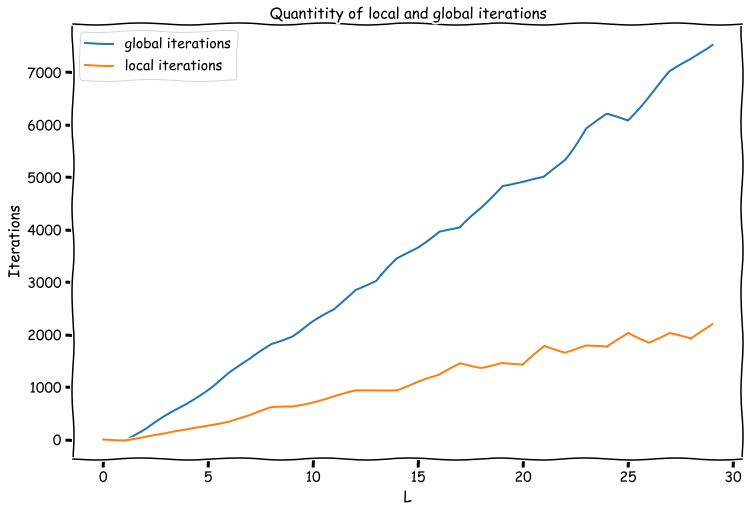

In [157]:
plt.figure(figsize=(12, 8))
plt.plot([i for i in range(30)], global_i, label = 'global iterations')
plt.plot([i for i in range(30)], local_i, label = 'local iterations')
plt.title("Quantitity of local and global iterations", fontsize = 15)
plt.xlabel("L", fontsize=15)
plt.ylabel("Iterations", fontsize=15)
plt.xkcd()
_ = plt.legend()

## Посмотрим как можно восстанавливается изображение в зависимости от L

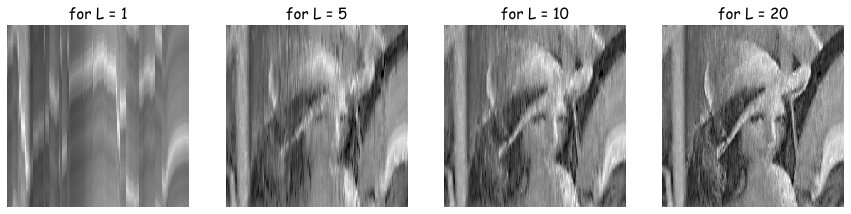

In [243]:
image = Image.open('lena1.jpg')
image = image.convert('L')
image = np.array(image).astype(np.float64)

l_1, _,_, approx_1, _, _ = Algorithm1(image.astype('complex'), 1)
l_2, _,_, approx_2, _, _ = Algorithm1(image.astype('complex'), 5)
l_3, _,_, approx_3, _, _ = Algorithm1(image.astype('complex'), 10)
l_4, _,_, approx_4, _, _ = Algorithm1(image.astype('complex'), 20)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10)) 

ax1.imshow(Image.fromarray(approx_1.real)) 
ax1.set_title("for L = 1", fontsize=15) 
ax1.axis('off') 

ax2.imshow(Image.fromarray(approx_2.real)) 
ax2.set_title("for L = 5", fontsize=15) 
ax2.axis('off') 

ax3.imshow(Image.fromarray(approx_3.real)) 
ax3.set_title("for L = 10", fontsize=15) 
_ = ax3.axis('off') 

ax4.imshow(Image.fromarray(approx_4.real)) 
ax4.set_title("for L = 20", fontsize=15) 
_ = ax4.axis('off') 

**As we see, by shifting the columns we are able to follow horizontal structures in the image. This becomes very clear looking at the most right image.**

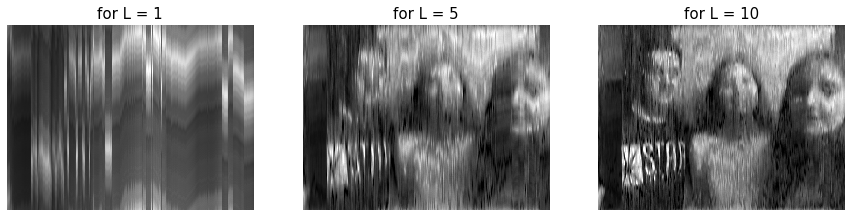

In [42]:
image = Image.open('us.jpg')
image = image.convert('L')
image = np.array(image).astype(np.float64)

l_1, _,_, approx_1, _, _ = Algorithm1(image.astype('complex'), 1)
l_2, _,_, approx_2, _, _ = Algorithm1(image.astype('complex'), 5)
l_3, _,_, approx_3, _, _ = Algorithm1(image.astype('complex'), 10)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10)) 

ax1.imshow(Image.fromarray(approx_1.real)) 
ax1.set_title("for L = 1", fontsize=15) 
ax1.axis('off') 

ax2.imshow(Image.fromarray(approx_2.real)) 
ax2.set_title("for L = 5", fontsize=15) 
ax2.axis('off') 

ax3.imshow(Image.fromarray(approx_3.real)) 
ax3.set_title("for L = 10", fontsize=15) 
_ = ax3.axis('off') 

plt.savefig('us3.png')

## Object identifying for seismic waves 

In [289]:
import numpy as np
import random
import cv2

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

image = cv2.imread('seismic.jpg',0) # Only for grayscale image
noise_img = sp_noise(image, 0.05)
cv2.imwrite('sp_noise.jpg', noise_img)

True

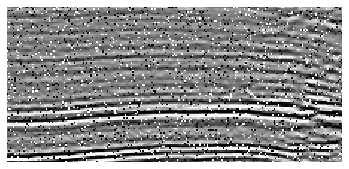

In [36]:
from matplotlib import pyplot as plt


img = Image.open('sp_noise.jpg').convert("L")
arr = np.asarray(img)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.axis('off') 
plt.show()

In [21]:
image = Image.open('sp_noise.jpg')
image = image.convert('L')
image = np.array(image).astype(np.uint8)

l_1, _,_, approx_1, _, _ = Algorithm1(image.astype('complex'), 1)
l_2, _,_, approx_2, _, _ = Algorithm1(image.astype('complex'), 2)

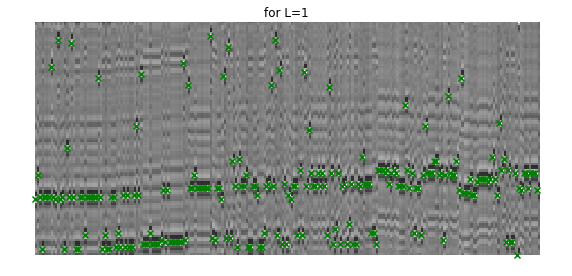

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.imshow(Image.fromarray(approx_1.real), extent=[0, approx_1.shape[1], 0, approx_1.shape[0]]) 
ax1.scatter(np.arange(approx_1.shape[1]), -l_1[0]%approx_1.shape[0], c = 'g', marker='x') 
ax1.set_title("for L=1") 
_ = ax1.axis('off') 

In [ ]:
image = Image.open('lena1.jpg')
image = image.convert('L')
image = np.array(image).astype(np.float64)

l_1, u_1, v_1, approx_1, _, _ = Algorithm1(image.astype('complex'), 1)
l_2, u_2, v_2, approx_2, _, _ = Algorithm1(image.astype('complex'), 5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10)) 

ax1.imshow(Image.fromarray(approx_1.real)) 
ax1.set_title("for L = 1", fontsize=15) 
ax1.axis('off') 

ax2.imshow(Image.fromarray(approx_2.real)) 
ax2.set_title("for L = 5", fontsize=15) 
ax2.axis('off') 